In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Compose, Resize, AutoAugment, RandomInvert, RandomGrayscale, RandomHorizontalFlip, RandomVerticalFlip, ConvertImageDtype, Normalize, RandomCrop
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")


# Imagenet Challenge 
## And the other datasets: MNIST, Fashion MNIST, CIFAR-10

I wamnt to code up Resnet, justifying it's structural need, using these datasets.  I want to see for myself:

- [ ] Linear models alone aren't good enough
- [ ] Convolution actually matters 
- [ ] Batch Norm matters
- [ ] Pooling matters
- [ ] Skip connections matter
- [ ] Large numbers of layers matter  

Etc...  Because I have found that most claims in the literature are correct, but some seem more solid than others.  Also, even the best claims typically break down at some point.  Only by testing with a skaptical eye can I truely understand. 

### Notes on Models:

**SingleLinear**:  This model only flattens the data then linearly maps to the targets classes:
* MNIST: lr = 1.0e-3, bacth_size=512, epochs = 100, train_loss = 0.27, val_loss = 0.27, accuracy = 0.93
* FashionMNIST: lr = 1.0e-3, bacth_size=512, epochs = 68, train_loss = 0.37, val_loss = 0.44, accuracy = 0.85
* CIFAR10: lr = 1.0e-3, bacth_size=512, epochs = 68, train_loss = 1.66, val_loss = 1.72, accuracy = 0.41

**DoubleLinear**:  This model flattens the data, has one layer of 128, then linearly maps to the targets classes
* MNIST: lr = 1.0e-3, bacth_size=512, epochs = 55, train_loss = 0.00, val_loss = 0.08, accuracy = 0.98
* FashionMNIST: lr = 4.0e-4, bacth_size=512, epochs = 45, train_loss = 0.24, val_loss = 0.34, accuracy = 0.88
* CIFAR10: lr = 4.0e-5, bacth_size=512, epochs = 68, train_loss = 1.26, val_loss = 1.39, accuracy = 0.51

**Resnet3**:  This model flattens the data, has one layer of 128, then linearly maps to the targets classes
* MNIST: lr = 1.0e-3, bacth_size=512, epochs = 55, train_loss = 0.02, val_loss = 0.07, accuracy = 0.98
* FashionMNIST: lr = 4.0e-4, bacth_size=512, epochs = 45, train_loss = 0.18, val_loss = 0.31, accuracy = 0.89
* CIFAR10: lr = 4.0e-5, bacth_size=512, epochs = 68, train_loss = 0.8, val_loss = 1.24, accuracy = 0.57

**Note:** For CIFAR10, Resnet3 has roughly the same parameters, 300k, except the paremeters were mostly moved to a single intital convolution layer.  Notice a signifigant improvement.  Evidence convolution parameters seem superior for linear for images. 

**Resnet4**:  This model flattens the data, has one layer of 128, then linearly maps to the targets classes
* MNIST: lr = 1.0e-3, bacth_size=512, epochs = 55, train_loss = 0.01, val_loss = 0.05, accuracy = 0.98
* FashionMNIST: lr = 4.0e-4, bacth_size=512, epochs = 45, train_loss = 0.06, val_loss = 0.29, accuracy = 0.91
* CIFAR10: lr = 4.0e-5, bacth_size=512, epochs = 68, train_loss = 0.51, val_loss = 1.2, accuracy = 0.60

**Note:** For CIFAR10, Resnet4 now has ~150k paremeters, except the paremeters moved to convolution layers other than the num_classes layer.  Notice more signifigant improvement despite less than hald the parameters.  Evidence convolution parameters seem superior for linear for images. 

**Resnet6**:  This model flattens the data, has one layer of 128, then linearly maps to the targets classes
* MNIST: lr = 1.0e-3, bacth_size=512, epochs = 55, train_loss = 0.00, val_loss = 0.04, accuracy = 0.99
* FashionMNIST: lr = 4.0e-4, bacth_size=512, epochs = 45, train_loss = 0.12, val_loss = 0.29, accuracy = 0.90
* CIFAR10: lr = 4.0e-5, bacth_size=512, epochs = 68, train_loss = 0.52, val_loss = 1.12, accuracy = 0.62

**Note:** For CIFAR10, Resnet6 now has ~100k paremeters from less linear and more convolution still.  Notice more improvement despite less parameters.  Evidence convolution parameters seem superior for linear for images

**Resnet8**:  This model flattens the data, has one layer of 128, then linearly maps to the targets classes
* MNIST: lr = 1.0e-3, bacth_size=512, epochs = 55, train_loss = 0.00, val_loss = 0.03, accuracy = 0.99
* FashionMNIST: lr = 4.0e-4, bacth_size=512, epochs = 45, train_loss = 0.12, val_loss = 0.29, accuracy = 0.90
* CIFAR10: lr = 4.0e-5, bacth_size=512, epochs = 68, train_loss = 0.58, val_loss = 1.14, accuracy = 0.61

**Resnet10**:  This model flattens the data, has one layer of 128, then linearly maps to the targets classes
* MNIST: lr = 1.0e-3, bacth_size=512, epochs = 55, train_loss = 0.00, val_loss = 0.03, accuracy = 0.99
* FashionMNIST: lr = 4.0e-4, bacth_size=512, epochs = 45, train_loss = 0.12, val_loss = 0.29, accuracy = 0.90
* CIFAR10: lr = 4.0e-5, bacth_size=512, epochs = 68, train_loss = 0.94, val_loss = 0.98, accuracy = 0.65


### Load the datasets

* MNIST
* Fashion MNIST
* CIFAR-10
* Imagenet

In [2]:
# Dataset Classes

def make_transforms(size=None, mean=0.0, augment=None):
    tt = [RandomCrop(32, padding=4), RandomHorizontalFlip(), ToTensor(), Normalize(mean=(0.4246, 0.4149, 0.3839), std=(0.2828,0.2779, 0.2844))]
    vt = [ToTensor(), Normalize(mean=(0.4942, 0.4851, 0.4504), std=(0.2467,0.2429, 0.2616))]
    #tt = [ToTensor(), ConvertImageDtype(dtype=torch.uint8), AutoAugment(), ConvertImageDtype(dtype=torch.float32), Normalize(mean=(0.4820, 0.4787, 0.4620), std=(0.2815,0.2795, 0.2896))]
    #vt = [ToTensor(), ConvertImageDtype(dtype=torch.uint8), AutoAugment(), ConvertImageDtype(dtype=torch.float32), Normalize(mean=(0.4820, 0.4787, 0.4620), std=(0.2815,0.2795, 0.2896))]



    '''
    if size is not None:
        tt.append(Resize((size,size)))
        vt.append(Resize((size,size)))

    if augment is not None:
        #tt.append(RandomInvert())
        #tt.append(RandomGrayscale())
        #tt.append(RandomGrayscale())
        #tt.append(RandomHorizontalFlip())
        #tt.append(RandomVerticalFlip())
        tt.append(ConvertImageDtype(dtype=torch.uint8))
        tt.append(AutoAugment())
        tt.append(ConvertImageDtype(dtype=torch.float32))
        tt.append(Normalize(mean=mean, std=1))
    '''

    train_transforms = Compose(tt)
    valid_transforms = Compose(vt)

    return train_transforms, valid_transforms


class MNIST:
    def __init__(self, batch_size=64, size=None, mean=0.0, augment=None) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(size, mean, augment)
        self.train = datasets.MNIST(root='data', train=True, transform=train_transforms)
        self.val = datasets.MNIST(root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)

class FashionMNIST:
    def __init__(self, batch_size=64, size=None, mean=0.0, augment=None) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(size, mean, augment)
        self.train = datasets.FashionMNIST(root='data', train=True, transform=train_transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)


class CIFAR10:
    def __init__(self, batch_size=64, size=None, mean=0.0, augment=None) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(size, mean, augment)
        self.train = datasets.CIFAR10(root='data', train=True, transform=train_transforms)
        self.val = datasets.CIFAR10(root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)


'''
class ImageNet:
    def __init__(self, batch_size=64, size=None) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(size)
        self.train = datasets.ImageNet(root='data', train=True, transform=train_transforms)
        self.val = datasets.ImageNet0(root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)
''';



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

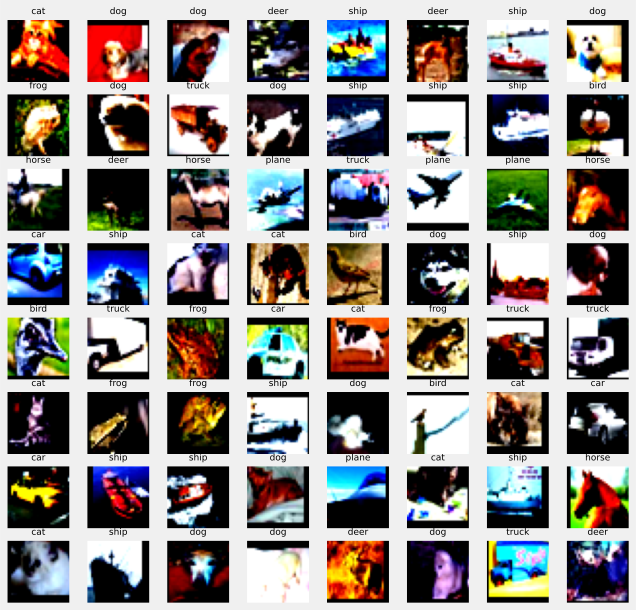

In [4]:
# Check out dataset
def plot_data_check(data, labels, title):
    plt.figure(figsize=(10, 10))
    x, y = next(iter(data.train_dl))

    for i in range(64):

        plt.subplot(8, 8, i+1)
        img = x.permute(0, 2, 3, 1)
        plt.imshow(img[i])
        plt.title(labels[y[i].item()], fontsize=9)
        plt.axis('off')


'''
# Test loading the data
# MNIST
data = MNIST()
labels = ['zero', 'one', 'two', 'three', 'four',
          'five', 'six', 'seven', 'eight', 'nine']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")

# Fashion MNIST
data = FashionMNIST()
labels = ['Shirt','Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")
'''

# CIFAR-10
#data = CIFAR10()
data = CIFAR10(batch_size=256)

labels = ['plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")



In [5]:
data = CIFAR10(batch_size=4096*4*2*2)

for x, y in data.train_dl:
    print (x[:,0,:,:].mean())
    print (x[:,1,:,:].mean())
    print (x[:,2,:,:].mean())
    print (x[:,0,:,:].std())
    print (x[:,1,:,:].std())
    print (x[:,2,:,:].std())

for x, y in data.val_dl:
    print (x[:,0,:,:].mean())
    print (x[:,1,:,:].mean())
    print (x[:,2,:,:].mean())
    print (x[:,0,:,:].std())
    print (x[:,1,:,:].std())
    print (x[:,2,:,:].std())

tensor(-0.0009)
tensor(-0.0010)
tensor(-0.0009)
tensor(1.0002)
tensor(1.0000)
tensor(1.0001)
tensor(5.7947e-05)
tensor(0.0001)
tensor(3.4809e-05)
tensor(0.9998)
tensor(1.0000)
tensor(1.0000)


### Models

#### Building up through ResNETs

In [6]:
# Base Model and building blocks
class MyModule(nn.Module):
    def __init__(self, lr=0.0001):
        super().__init__()
        self.learning_rate = lr

    def forward(self, x):
        out = self.model(x)
        return out

    def init_cnn(self, module):  # @save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            # nn.init.xavier_uniform_(module.weight)
            nn.init.kaiming_normal_(
                module.weight, mode='fan_in', nonlinearity='relu')

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

    def loss_fn(self, logits, y):
        loss = nn.functional.cross_entropy(logits, y)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate)


class Residule(nn.Module):
    def __init__(self, out_channels, stride=1, do_conv=True) -> None:
        super().__init__()
        self.conv1 = nn.LazyConv2d(
            out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.do_conv = do_conv
        if self.do_conv:
            self.conv3 = nn.LazyConv2d(
                out_channels, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.do_conv:
            x = self.bn3(self.conv3(x))
        out += x
        return torch.relu(out)


In [7]:
# Single Linear Model
class SingleLinear(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_classes))

# Double


class DoubleLinear(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(), nn.LazyLinear(
            128), nn.ReLU(), nn.LazyLinear(num_classes))

# Resnet3
class Resnet3(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.LazyConv2d(16, kernel_size=3, padding=1), nn.BatchNorm2d(16), 
                     nn.ReLU(), nn.Flatten(),  nn.LazyLinear(100), nn.ReLU(), nn.LazyLinear(num_classes))


# Resnet4
class Resnet4(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.LazyConv2d(16, kernel_size=3, padding=1), nn.BatchNorm2d(16), 
        nn.ReLU(), Residule(16, do_conv=False), nn.Flatten(),  nn.LazyLinear(num_classes))

# Resnet6
class Resnet6(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.LazyConv2d(16, kernel_size=3, padding=1), nn.BatchNorm2d(16), 
        nn.ReLU(), Residule(16, do_conv=False), Residule(32, stride=2), nn.Flatten(),  nn.LazyLinear(num_classes))

# Resnet8
class Resnet8(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.LazyConv2d(16, kernel_size=3, padding=1), nn.BatchNorm2d(16), 
        nn.ReLU(), Residule(16, do_conv=False), Residule(32, stride=2), Residule(64, stride=2), nn.Flatten(),  nn.LazyLinear(num_classes))


# Resnet10
class Resnet10(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.LazyConv2d(16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), 
        Residule(16, do_conv=False), Residule(16, do_conv=False),
        Residule(32, stride=2), 
        Residule(64, stride=2), 
        nn.Flatten(),  nn.LazyLinear(num_classes))

# Resnet10
class Resnet14(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.LazyConv2d(16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), 
        Residule(16, do_conv=False), Residule(16, do_conv=False),
        Residule(32, stride=2), Residule(32, do_conv=False),
        Residule(64, stride=2), Residule(64, do_conv=False),
        nn.Flatten(),  nn.LazyLinear(num_classes))

class Resnet20(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(nn.LazyConv2d(16, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(16), nn.ReLU(), 
        Residule(16, do_conv=False), Residule(16, do_conv=False), Residule(16, do_conv=False),
        Residule(32, stride=2), Residule(32, do_conv=False), Residule(32, do_conv=False),
        Residule(64, stride=2), Residule(64, do_conv=False), Residule(64, do_conv=False),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),  nn.LazyLinear(num_classes))


In [8]:
# Test Models
device = "mps"

# Data
# data = MNIST()
# data = FashionMNIST()
data = CIFAR10()

# Model
# model = SingleLinear().to(device)
# model = DoubleLinear().to(device)
# model = Resnet3().to(device)
# model = Resnet4().to(device)
# model = Resnet6().to(device)
# model = Resnet8().to(device)
model = Resnet20().to(device)


# Get instance
x, y = next(iter(data.train_dl))
x, y = x.to(device), y.to(device)

print('\n* x array shape:')
print(x.shape)

print('\n* Logits array shape:')
logits = model.init(x)
print(logits.shape)

# Number of parameters
print(f'\n* Model "{model.__class__.__name__}" has \
{sum([p.numel() for p in model.parameters()])} parameters')

print('\n* Model:')
print(model)



* x array shape:
torch.Size([64, 3, 32, 32])

* Logits array shape:
torch.Size([64, 10])

* Model "Resnet20" has 272954 parameters

* Model:
Resnet20(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Residule(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Residule(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, ke

Model "Resnet20" has 272954 parameters
Epoch   0 has train loss 2.3858, val loss 2.3858, and accuracy 0.0781
Epoch   5 has train loss 0.8960, val loss 1.2218, and accuracy 0.5656
Epoch  10 has train loss 0.5882, val loss 0.8589, and accuracy 0.7164
Epoch  15 has train loss 0.5254, val loss 0.7509, and accuracy 0.7625
Epoch  20 has train loss 0.5282, val loss 0.7426, and accuracy 0.7586
Epoch  25 has train loss 0.4039, val loss 0.7469, and accuracy 0.7602
Epoch  30 has train loss 0.4429, val loss 0.7811, and accuracy 0.7531
Epoch  35 has train loss 0.3672, val loss 0.6500, and accuracy 0.7898
Epoch  40 has train loss 0.3190, val loss 0.5770, and accuracy 0.8000
Epoch  45 has train loss 0.3333, val loss 0.6019, and accuracy 0.8086
Epoch  50 has train loss 0.3353, val loss 0.5846, and accuracy 0.8125
Epoch  55 has train loss 0.3135, val loss 0.5597, and accuracy 0.8352
Epoch  60 has train loss 0.2700, val loss 0.5479, and accuracy 0.8391
Epoch  65 has train loss 0.2390, val loss 0.4814, a

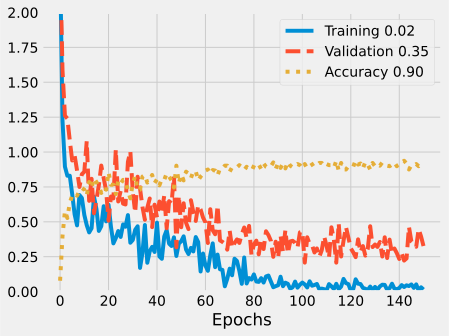

In [10]:
device = "mps"
max_epochs = 150
train_lr = False
LR = 0.1
batch_size = 256

try:
    del (model)
    del (x)
    del (y)
    del (vx)
    del (vy)
except:
    pass

# Data
# data = MNIST(batch_size=batch_size)
# data = FashionMNIST(batch_size=batch_size, mean=0.286)
data = CIFAR10(batch_size=batch_size)


# Model
# model = SingleLinear().to(device)
# model = DoubleLinear().to(device)
# model = Resnet3().to(device)
# model = Resnet4().to(device)
# model = Resnet6().to(device)
# model = Resnet8().to(device)
# model = Resnet14().to(device)
model = Resnet20().to(device)


# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to(device), y.to(device)
val_logits = model.init(x)

# Number of parameters
print(
    f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')


# Initial loss
val_loss = model.loss_fn(val_logits, y).item()
val_acc = model.accuracy(val_logits, y).item()
print(f'Epoch {0:>3d} has train loss {val_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')
del (x)
del (y)

N = len(data.train_dl)
lr = torch.logspace(-6, 0, N)
losses = torch.zeros(N)
min_loss = 9999999.
min_epoch = 0
if train_lr is False:
    #model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    model.optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
    #scheduler = ReduceLROnPlateau(
    #    model.optimizer, 'min', factor=0.25, verbose=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max=100, verbose=False)
epochs = [0]
ptloss = [val_loss]
pvloss = [val_loss]
pvacc = [val_acc]
for epoch in range(1, max_epochs+1):
    model.train()
    for step, batch in enumerate(data.train_dl):

        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        losses[step] = train_loss.item()

        # Update
        if train_lr:
            #model.optimizer = torch.optim.AdamW(
            #    model.parameters(), lr=lr[step])
            model.optimizer = torch.optim.SGD(model.parameters(), lr=lr[step], momentum=0.9, weight_decay=5e-4)
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        # if step % 20 == 0:
        #    print(f'step {step} has loss {train_loss.item()}')

        del (x)
        del (y)
    if train_lr:
        break
    # Evaluate for epoch
    model.eval()
    with torch.no_grad():
        vx, vy = next(iter(data.val_dl))
        vx, vy = vx.to(device), vy.to(device)
        val_logits = model(vx)
        val_loss = model.loss_fn(val_logits, vy)
        val_acc = model.accuracy(val_logits, vy)
        epochs.append(epoch)
        ptloss.append(train_loss.item())
        pvloss.append(val_loss.item())
        pvacc.append(val_acc.item())
        #scheduler.step(val_loss)
        scheduler.step()

        del (vx)
        del (vy)

        # Early Stopping
        if val_loss < min_loss:
            min_loss = val_loss
            min_epoch = epoch
        else:
            if epoch - 40 > min_epoch:
                break

    if epoch % 5 == 0:
        avetloss = torch.tensor(ptloss[-5:]).mean().item()
        avevloss = torch.tensor(pvloss[-5:]).mean().item()
        avevacc = torch.tensor(pvacc[-5:]).mean().item()
        # train_loss.item()
        print(
            f'Epoch {epoch:>3d} has train loss {avetloss:.4f}, val loss {avevloss:.4f}, and accuracy {avevacc:.4f}')

    if epoch == 100:
        print (LR/100.)
        model.optimizer = torch.optim.SGD(model.parameters(), lr=LR/100., momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max=50, verbose=False)

    if epoch == 150:
        print (LR/100.)
        model.optimizer = torch.optim.SGD(model.parameters(), lr=LR/100., momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max=50, verbose=False)

    # break



if train_lr is False:
    # Get final training loss:
    model.eval()
    ftloss = []
    for batch in data.train_dl:
        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        ftloss.append(train_loss.item())

        del (train_loss)
        del (x)
        del (y)

    fvloss = []
    fvacc = []
    for batch in data.val_dl:
        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        val_logits = model(x)

        # Get loss
        val_loss = model.loss_fn(val_logits, y)
        val_acc = model.accuracy(val_logits, y)
        fvloss.append(val_loss.item())
        fvacc.append(val_acc.item())

        del (x)
        del (y)
        del (val_loss)
        del (val_acc)

    ftloss = torch.tensor(ftloss).mean().item()
    fvloss = torch.tensor(fvloss).mean().item()
    fvacc = torch.tensor(fvacc).mean().item()

    # Plot
    plt.figure()
    # epochs = torch.arange(max_epochs + 1).detach()
    plt.plot(epochs, ptloss, 'C0-', label=f'Training {ftloss:.2f}')
    plt.plot(epochs, pvloss, 'C1--', label=f'Validation {fvloss:.2f}')
    plt.plot(epochs, pvacc, 'C2:', label=f'Accuracy {fvacc:.2f}')
    plt.ylim(0, 2)
    plt.xlabel('Epochs')
    plt.legend()
else:
    plt.semilogx(lr, losses)


In [24]:
0.1*0.5*(1 + torch.cos(torch.tensor(3.14159*190.0/200.)))

tensor(0.0006)